## 분석 라이브러리 불러오기 : Numpy, sklearn, graphviz 등

In [80]:
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm

# 그래프 Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
mpl.rcParams['axes.unicode_minus'] = False
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
mpl.rc('font',family= font_name)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Decision tree

from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#랜덤 포레스트
from sklearn.ensemble import RandomForestRegressor

#그래디언트 부스팅
from sklearn.ensemble import GradientBoostingRegressor

#서포트 벡터 머신

# 정규분포 및 회귀분석 등
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

#스케일링
from sklearn.preprocessing import scale, minmax_scale, robust_scale
#다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor
#선형 회귀모형
from sklearn.linear_model import LinearRegression
#변수선택법 (후진제거법)
from sklearn.feature_selection import RFE
#스케일 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler

# 분석할 파일 불러오기 및 형태 파악(행, 열 구조 확인)

In [81]:
df_raw = pd.read_csv("/home/pirl/Statistics/Day3_0715/Concrete.csv", engine = "python", encoding="CP949")
df_raw.shape

(1030, 9)

## 분석할 파일 개요 확인

In [82]:
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## Gradient Boosting 분석을 위해, X변수와, Y변수로 나누어줌

In [83]:
df_raw_y = df_raw['CONCRETE_COMPRESSIVE_STRENGTH']
df_raw_x = df_raw.drop("CONCRETE_COMPRESSIVE_STRENGTH", axis = 1, inplace = False)

# Train/Test/Validation 테스트/최종 테스트를 위해 데이터를 0.3/0.4/0.3 비중으로 나누어줌

In [84]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state=1234)
df_train_x, df_val_x, df_train_y, df_val_y = train_test_split(df_train_x, df_train_y, test_size = (0.3/0.7), random_state=1234)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))
print("validation data X size : {}".format(df_val_x.shape))
print("validation data Y size : {}".format(df_val_y.shape))

train data X size : (412, 8)
train data Y size : (412,)
test data X size : (309, 8)
test data Y size : (309,)
validation data X size : (309, 8)
validation data Y size : (309,)


# 전처리 끝난 Train Data를 이용해 최초 모델링 실시 (랜덤 state는 1234로 지정)

In [109]:
gb_uncustomized = GradientBoostingRegressor(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set : {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
print("Score on test set : {:.3f}".format(gb_uncustomized.score(df_val_x, df_val_y)))

Score on training set : 0.957
Score on test set : 0.837


# Tree 개수 조절해가며 Decision Tree 모델링 실시 (Leaf 10~100 시도)

In [86]:
train_score = []; test_score = []

para_n_tree = [n_tree * 10 for n_tree in range (1,11)]

for v_n_estimators in para_n_tree :
    gb = GradientBoostingRegressor(random_state = 1234
                                   ,n_estimators=v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_val_x, df_val_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score


df_score_n["D"] = df_score_n["TrainScore"]-df_score_n["TestScore"]

df_score_n.round(3)

,n_estimators,TrainScore,TestScore,D
0,10,0.666,0.565,0.101
1,20,0.827,0.718,0.109
2,30,0.885,0.781,0.104
3,40,0.911,0.804,0.107
4,50,0.926,0.814,0.112
5,60,0.936,0.823,0.113
6,70,0.943,0.830,0.112
7,80,0.948,0.833,0.115
8,90,0.953,0.837,0.117
9,100,0.957,0.837,0.119


# 아래 그래프로 판단했을때, 모델이 Test 샘플을 설명하는 설명력이 가장 높은 지점인 트리 수를 90으로 설정

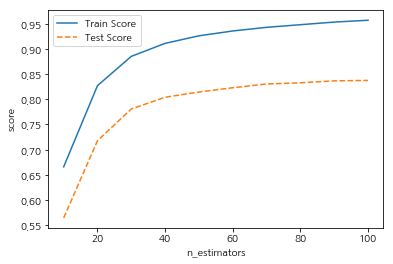

In [87]:
plt.plot(para_n_tree, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_n_tree, test_score, linestyle = '--', label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

# Leaf 조절해가며 모델링 실시 (Leaf 1~100 시도)

In [88]:
train_score = []; test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range (1,101)]

for v_min_samples_leaf in para_leaf :
    gb = GradientBoostingRegressor(random_state = 1234, n_estimators = 90,
                                   min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_val_x, df_val_y))
    
df_score_n = pd.DataFrame()
df_score_n["MinSamplesLeaf"] = para_leaf
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score


df_score_n["D"] = df_score_n["TrainScore"]-df_score_n["TestScore"]

df_score_n.round(3)

,MinSamplesLeaf,TrainScore,TestScore,D
0,1,0.953,0.837,0.117
1,2,0.952,0.842,0.110
2,3,0.952,0.844,0.108
3,4,0.953,0.844,0.109
4,5,0.953,0.847,0.106
5,6,0.950,0.845,0.105
6,7,0.949,0.848,0.101
7,8,0.949,0.840,0.109
8,9,0.946,0.850,0.096
9,10,0.946,0.843,0.104


# 아래 그래프로 판단했을때, 모델이 Test 샘플을 설명하는 설명력이 가장 높은 지점인 최소 Leaf 샘플 수를 9로 설정

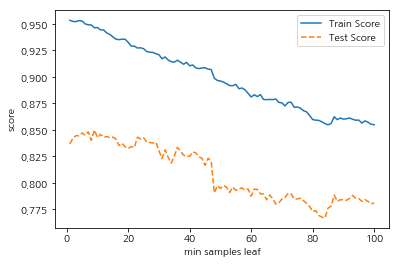

In [89]:
plt.plot(para_leaf, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

# Leaf 설정이 끝난 후, 노드의 크기를 설정할 차례, 18부터 200까지 변경해가며 모델링 실시

In [90]:
train_score = []; test_score = []

para_split = [n_split * 2 for n_split in range(9, 101)]

for v_min_samples_split in para_split :
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = 90, min_samples_leaf=9,
                                    min_samples_split = v_min_samples_split)
    gb.fit (df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_val_x, df_val_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSampleSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score


df_score_split["D"] = df_score_split["TrainScore"]-df_score_split["TestScore"]

df_score_split.round(3)

,MinSampleSplit,TrainScore,TestScore,D
0,18,0.946,0.850,0.096
1,20,0.943,0.850,0.093
2,22,0.943,0.846,0.098
3,24,0.944,0.848,0.096
4,26,0.944,0.845,0.098
5,28,0.942,0.844,0.098
6,30,0.944,0.845,0.098
7,32,0.942,0.845,0.097
8,34,0.941,0.839,0.102
9,36,0.940,0.843,0.097


# 아래 그래프로 미뤄보아, 모델이 Test 샘플을 설명하는 설명력이 가장 높은 지점인 최소 노드의 샘플 수를 96으로 설정

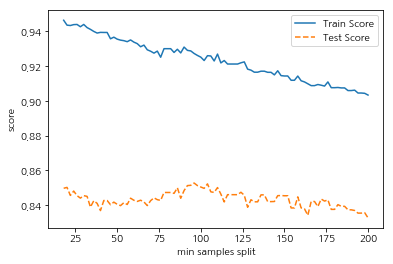

In [91]:
plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

# Leaf, 노드 샘플 크기 설정이 끝난 후, 깊이를 설정할 차례, 1부터 20 까지 변경해가며 모델링 실시

In [92]:
train_score = []; test_score = []

para_depth = [depth for depth in range(1, 21)]

for v_max_depth in para_depth :
    gb = GradientBoostingRegressor(random_state=1234, n_estimators = 90, min_samples_leaf=9, min_samples_split =96,
                                    max_depth = v_max_depth)
    gb.fit (df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_val_x, df_val_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score


df_score_depth["D"] = df_score_depth["TrainScore"]-df_score_depth["TestScore"]

df_score_depth.round(3)

,Depth,TrainScore,TestScore,D
0,1,0.830,0.745,0.084
1,2,0.898,0.820,0.078
2,3,0.927,0.853,0.074
3,4,0.945,0.863,0.082
4,5,0.951,0.868,0.083
5,6,0.958,0.874,0.084
6,7,0.959,0.876,0.084
7,8,0.963,0.880,0.083
8,9,0.962,0.877,0.085
9,10,0.964,0.874,0.090


# 아래 그래프 확인 시, Depth 8에서 모델이 Test 샘플을 설명하는 설명력이 가장 높게 나타남

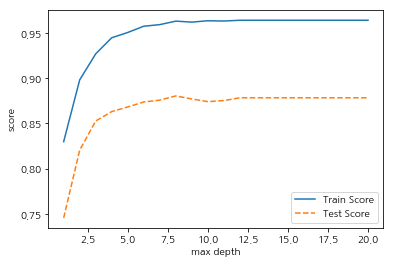

In [93]:
plt.plot(para_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = '--', label = "Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

# 모든 크기 설정이 끝난 후, 깊이를 설정할 차례, 0.1부터 10 까지 변경해가며 모델링 실시

In [95]:
train_score = []; test_score = []

para_lr = [lr * 0.1 for lr in range(1, 10)]

for v_learning_rate in para_lr :
    gb = GradientBoostingRegressor(n_estimators = 90, min_samples_leaf=9, min_samples_split =96,
                                   max_depth =8, learning_rate = v_learning_rate)
    gb.fit (df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_val_x, df_val_y))
    
df_score_lr = pd.DataFrame()
df_score_lr["Learning Rate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score


df_score_lr["D"] = df_score_lr["TrainScore"]-df_score_lr["TestScore"]

df_score_lr.round(3)

,Learning Rate,TrainScore,TestScore,D
0,0.1,0.963,0.880,0.083
1,0.2,0.979,0.881,0.098
2,0.3,0.987,0.879,0.107
3,0.4,0.990,0.884,0.106
4,0.5,0.992,0.879,0.113
5,0.6,0.993,0.884,0.109
6,0.7,0.994,0.839,0.155
7,0.8,0.994,0.854,0.141
8,0.9,0.995,0.869,0.126


# 아래 그래프 확인 시, Learning rate 0.1에서 모델이 Test 샘플을 설명하는 설명력이 높으면서 Train Set과 차이가 가장 적음

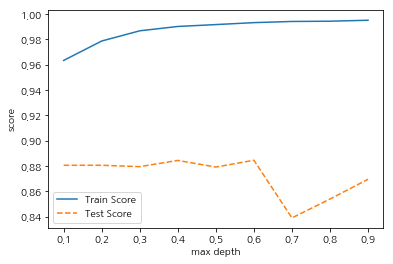

In [96]:
plt.plot(para_lr, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_lr, test_score, linestyle = '--', label = "Test Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

# 최종 모델을 위에서 확인한 것과 같이, 아래 식으로 설정함 (n_estimator 90 / leaf 9 / split 96 / depth 8 / learninrate = 0.1)
# Train Data 예측 확률은 96.3%, Validation Data 예측 확률은 88%이며, 최종적으로 Test Data를 이용해 최종적으로 모델링을 검증해 보니, 설명력은 90.2%로 나타남
# 콘크리트 강도를 예측하는 모델의 정확성은 약 90% 수준이며, 이전 예측에 사용했던 Decision Tree나, Random Forest 대비 모델링의 설명력이 우수하므로, 콘크리트 경도를 예측하는데 그 두 가지 모델보다 적합한 모델이라 할 수 있다

In [105]:
gb_final = GradientBoostingRegressor(random_state=1234, n_estimators = 90, min_samples_leaf=9, min_samples_split =96,
                                   max_depth =8, learning_rate =0.1)
gb_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(gb_final.score(df_train_x,df_train_y)))
print("score on test set: {:.3f}".format(gb_final.score(df_val_x,df_val_y)))
print("score on Final: {:.3f}".format(gb_final.score(df_test_x,df_test_y)))

Score on training set: 0.963
score on test set: 0.880
score on Final: 0.902


# 완료된 모델을 이용하여, 테스트 데이터의 예측값을 아래와 같이 계산할 수 있다.

In [53]:
y_predict=gb_final.predict(df_test_x)
y_pre = pd.DataFrame()
y_pre['Predict'] = y_predict

y_pre

,Predict
0,16.706983
1,16.350796
2,56.243398
3,16.990250
4,41.801739
5,52.495876
6,27.877445
7,45.149417
8,29.841540
9,71.680372


# 변수별 중요도는 아래와 같이 나타났다

In [106]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,AGE,0.339
0,CEMENT,0.299
3,WATER,0.215
1,BLAST_FURNACE_SLAG,0.068
4,SUPERPLASTICIZER,0.028
6,FINE_AGGREGATE,0.025
5,COARSE_AGGREGATE,0.018
2,FLY_ASH,0.009


Text(0, 0.5, '변수')

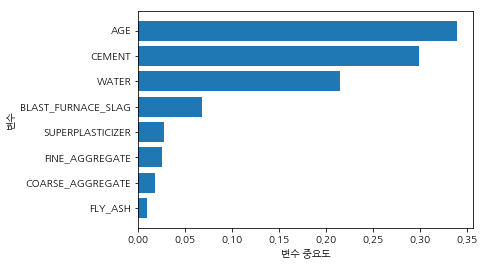

In [107]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

# 모델의 mse와 msa는 아래와 같이 계산할 수 있다.

In [108]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("MAE: {:.3f}".format(mean_absolute_error(df_test_y, gb_final.predict(df_test_x))))
print("MSE: {:.3f}".format(mean_squared_error(df_test_y, gb_final.predict(df_test_x))))

MAE: 3.704
MSE: 25.597


## MAE는 모델과 각 수치간 평균 절대 오차(|Xi-X바|), MSE는 평균 제곱 오차(|Xi-X바|**2)를 뜻하며, 이 두 수치가 0에 가까울 수록, 모델의 오차가 적다고 볼 수 있다.